# Offline hand-eye callibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys
import glob

from apriltag import apriltag

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, show_detections, compute_hand_eye_calibration, quat2mat, mat2quat, frame_is_valid

In [2]:
data_root = '../../../../../data/cobot/calibration/calibdata_2025_08_07-13_59_11'
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

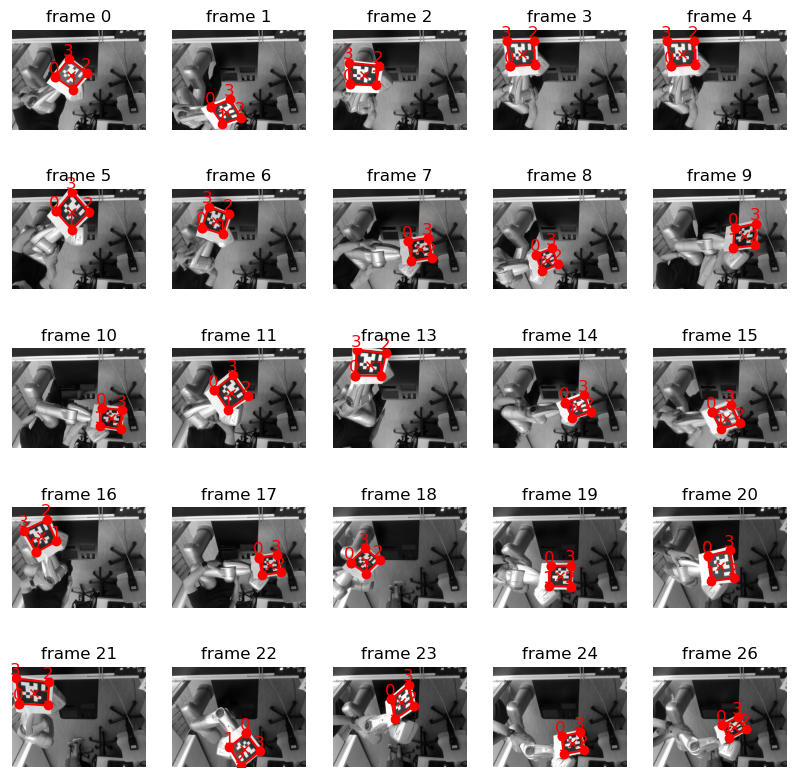

In [3]:
apriltag_family = 'tag36h11'
detector = apriltag(apriltag_family)

num_frames = len(glob.glob1(data_root, "frame_*.pkl"))
plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, num_frames-1, min(num_frames, 25), dtype=int)): 
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [4]:
frame, gray, detections = load_and_detect(10, data_root, detector)
frame

{'image_timestamp': (1754575237, 618218750),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', 0.0), ('y', 0.0), ('z', 0.0)])),
              ('rotation',
               OrderedDict([('x', 0.0),
                            ('y', 0.0),
                            ('z', 0.0),
                            ('w', 1.0)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754575237),
                                          ('nanosec', 217923584)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
              ('k',
               [608.028076171875,
                0.0,
                319.5732727050781,
                0.0,
                606.673583984375,
          

In [5]:
#frame_samples = [0, 3, 13, 16, 27, 30, 33, 37, 40, 47, 54, 64, 70, 77]
#frame_samples = [0, 2, 6, 10, 19, 22, 26, 29, 31, 33, 35, 36, 37, 39, 41, 47, 53, 64, 72, 78]
frame_samples = [18, 19, 20, 21, 22, 23, 24, 25, 26]

for frame_count in frame_samples:
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)
    if not frame_is_valid(frame, detections):
        print(f"Error: Invalid frame {frame_count}")

In [6]:
tagsize = 0.14  # Size of the tag in meters
hand_camera_rot, hand_camera_tr, hand_camera_qwxyz = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

Hand-Eye Calibration Results:
Rotation Matrix:
[[-0.98913989 -0.03908442  0.14168518]
 [ 0.06482991  0.74912901  0.65924412]
 [-0.13190666  0.66127009 -0.73845955]]
Quaternion (wxyz):
[0.0733648  0.00690376 0.93229937 0.35410144]
Translation Vector:
[[-0.63426708]
 [-0.4647432 ]
 [ 1.55680615]]


Reference: 

```bash
Hand-Eye Calibration Results:
Rotation Matrix:
[[ 0.99084876 -0.06789273 -0.11665893]
 [ 0.05717175  0.99403161 -0.09291156]
 [ 0.12227068  0.08539171  0.98881653]]
Quaternion (wxyz):
[ 0.99670669  0.04472311 -0.05992977  0.03136943]
Translation Vector:
[[-0.25556454]
 [ 0.50022198]
 [ 1.02821659]]
```

In [7]:
calibration_file = '../../../handeye_calibration.json'
save_calibration(calibration_file, calibration_config, hand_camera_qwxyz.tolist(), hand_camera_tr.tolist(), 
                 frame_samples, data_root)

loaded_calibration = load_calibration(calibration_file)
print("Loaded Calibration:")
print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'TCP', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.6342670780249285], [-0.46474320072893893], [1.5568061459562252]], 'rotation_q_wxyz': [0.07336480292253321, 0.006903759234536126, 0.9322993674848729, 0.35410144476953975], 'selected_samples': [18, 19, 20, 21, 22, 23, 24, 25, 26], 'data_file_path': '../../../../../data/cobot/calibration/calibdata_2025_08_07-13_59_11'}


## Stability testing

In [8]:
samples = frame_samples
for i in range(5):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples, detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('permutation=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())
    samples = np.random.permutation(frame_samples)

permutation=00 : rotation:  [0.02073077 2.79953016 1.06330403] , translation:  [-0.63426708 -0.4647432   1.55680615]
permutation=01 : rotation:  [0.02073077 2.79953016 1.06330403] , translation:  [-0.6332333  -0.46331432  1.55816322]
permutation=02 : rotation:  [0.02073077 2.79953016 1.06330403] , translation:  [-0.63356008 -0.46852158  1.55349008]
permutation=03 : rotation:  [0.02073077 2.79953016 1.06330403] , translation:  [-0.63363956 -0.4661822   1.5553358 ]
permutation=04 : rotation:  [0.02073077 2.79953016 1.06330403] , translation:  [-0.63292511 -0.46784086  1.55416706]


In [9]:
samples = np.random.permutation(frame_samples)
for i in range(5, len(samples)+1):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples[:i], detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('len=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())


len=05 : rotation:  [0.03464451 2.78970877 1.09973864] , translation:  [-0.62970458 -0.48641002  1.54613137]
len=06 : rotation:  [0.03627092 2.79115273 1.10121001] , translation:  [-0.62803251 -0.48576528  1.54643921]
len=07 : rotation:  [0.0266802  2.78384717 1.09110766] , translation:  [-0.6368144  -0.47519535  1.54631386]
len=08 : rotation:  [0.02763226 2.78565873 1.09304815] , translation:  [-0.6339513  -0.47337619  1.54587932]
len=09 : rotation:  [0.02073077 2.79953016 1.06330403] , translation:  [-0.63312164 -0.4679342   1.55311576]


## Reprojection test

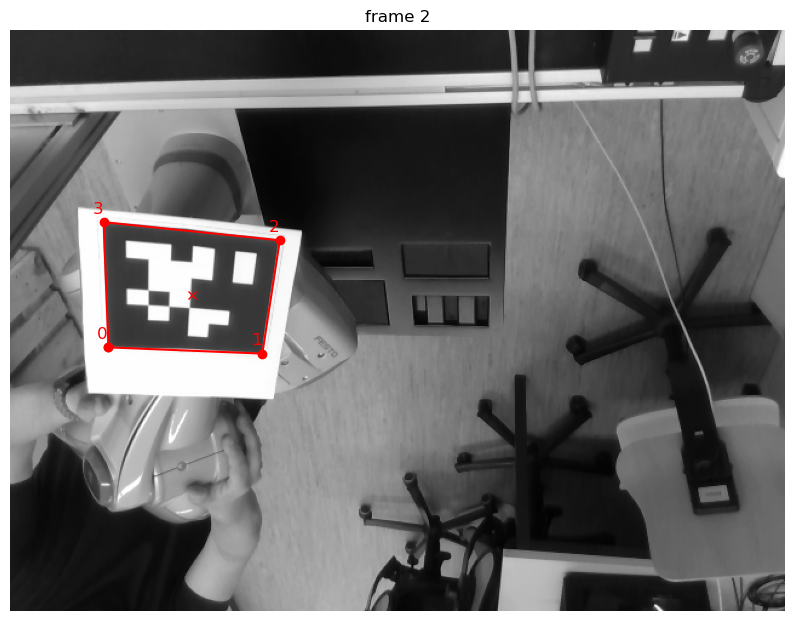

In [10]:
frame_count = 2
frame, gray, detections = load_and_detect(frame_count, data_root, detector)
plt.figure(figsize=(10, 10))
show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
plt.title('frame %d' % frame_count);

In [11]:
robot_trans = [frame['robot_transform']['translation']['x'], frame['robot_transform']['translation']['y'], frame['robot_transform']['translation']['z']]
robot_trans

robot_quat_wxyz = [frame['robot_transform']['rotation']['w'], frame['robot_transform']['rotation']['x'], frame['robot_transform']['rotation']['y'], frame['robot_transform']['rotation']['z']]

robot_rmat = quat2mat(robot_quat_wxyz)

TCP_world = robot_rmat @ np.array([0,0,0]).reshape(3, 1) +  np.array(robot_trans).reshape(3, 1)

robot_trans, robot_quat_wxyz, robot_rmat, TCP_world

#hand_camera_rot, hand_camera_tr

d = np.array(frame['camera_info']['d'])
K = np.array(frame['camera_info']['k']).reshape(3, 3)

rvec, _ = cv2.Rodrigues(hand_camera_rot)
img_points, _ = cv2.projectPoints(objectPoints=TCP_world, rvec=rvec, tvec=hand_camera_tr, cameraMatrix=K, distCoeffs=d)

TCP_world, img_points

(array([[0.],
        [0.],
        [0.]]),
 array([[[71.85316174, 74.15850196]]]))

In [12]:
-np.transpose(hand_camera_rot) @ hand_camera_tr

array([[-0.39189651],
       [-0.70610669],
       [ 1.54588383]])